# **Sparsity Invariant Convolution Neural Network**
### **Introduction**
This notebook is the [TensorFlow](https://www.tensorflow.org/) based implementation of the [research paper](https://arxiv.org/pdf/1708.06500.pdf) on the **Sparsity Invariant CNNs**. Since the size of the dataset is **large** and the network being **large** in size it is **recommended** to run this notebook on a cloud coumputing services like [**Google Colab**](https://colab.research.google.com/). The dataset is also stored on **Google Drive** for seamless integration with Google Colab.



### **Step I** : Connecting to the File System 
In this step we will basically use the in-built python `OS library` and the `google colab drive connector` to connect with the Google Drive and traverse through the file system.<br>
Run the first two cells and in the second cell click on the link provided the by the output to enter the authorisation code which will mount the drive onto your colab notebook to be accessed.

In [0]:
import os

In [2]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### **Step II** : Creating function for Proccessing the Depth Image Data
Function `depth_read(filename)` is taken from the [development kit](http://www.cvlibs.net/downloads/depth_devkit.zip) provided by the [KTTI dataset](http://www.cvlibs.net/datasets/kitti/eval_depth.php?benchmark=depth_completion). Altough the function has been modified to suite our needs. The aim of the function is to assert that **only 16-bit** depth maps are processed and outputs a `np.array` which is far more *readable* and *convertible* than the binary output of the *.png depth* image file.

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
from PIL import Image
import numpy as np


def depth_read(filename):
    # loads depth map D from png file
    # and returns it as a numpy array,
    # for details see readme.txt

    depth_png = np.array(Image.open(filename), dtype=int)
    # make sure we have a proper 16bit depth map here.. not 8bit!
    assert(np.max(depth_png) > 255)

    depth = depth_png.astype(np.float) / 256
    return depth


### **Step III** : Creating the dataset
The above defined functions along with standard file traversal algorithms are used to traverse the **training data** file system and populate the array and using that array to populate a *.npy binary file* which can be used later on for training or for subsequent runs.<br>
**Why create a binary file instead of file traversal while training?**


1.   File traversal is slow and takes time to read a particular file as it involves mounting a file on the memory and then reading it.
2.   Tensorflow uses `np.array` as a fundamental datatype and hence we need to convert a file output from **binary output** to **Numpy Array**.
3.   Training is a **GPU optimized process** and file-handling is a **CPU optimized process** and hence back and forth between these resources will take additional time too.
4.   Training takes place in batches. It is better to train a network by providing a batch of training data rather than one input per batch and hence populating subsequent batches will be time consuming process.

```python
REBUILD_DATA = False
```
This can be set to `True` or `False` as per the requirements of rebuilding the training data or not. We have used a subset of training data as the KTTI dataset provides with 93K depth map images but due to limited resources we can only use subset of around 600-1300 images for training and validation.

```python
from tqdm import tqdm
```
**Tqdm** is a python library which shows the **progress bar** for any loop to show the time taken per iteration and percentage of operation which has taken place.

**NOTE:**<br>
The network trains **significantly** better when the training data has value between 0-1 instead of standard 0-255. This can be achieved by mutiplying the output by 1/255 as follows-
```python
input_data = depth_read(os.path.join(DIR, 'velodyne_raw', 'image_02', output_file)) 
```  
to 
```python
input_data = depth_read(os.path.join(DIR, 'velodyne_raw', 'image_02', output_file)) * 1/255
```
and 
```python
output_data = depth_read(os.path.join(SUB_DIR, output_file))
```  
to 
```python
output_data = depth_read(os.path.join(SUB_DIR, output_file)) * 1/255
```

In [0]:
ROOT_DIR = '/content/drive/My Drive/NNFL Assignment/'
PROJECT_DIR = os.path.join(ROOT_DIR,'train')
FOLDER_LIST = os.listdir(PROJECT_DIR)[:2]

In [0]:
from tqdm import tqdm
REBUILD_DATA = False
training_data = []
total_files = 0

def make_training_data():
    global total_files
    for folder in FOLDER_LIST:
        DIR = os.path.join(PROJECT_DIR, folder, 'proj_depth')
        for output_file in tqdm(os.listdir(os.path.join(DIR, 'groundtruth','image_02'))):
            SUB_DIR = os.path.join(DIR, 'groundtruth','image_02')
            try:
                input_data = depth_read(os.path.join(DIR, 'velodyne_raw', 'image_02', output_file)) 
                output_data = depth_read(os.path.join(SUB_DIR, output_file))
                training_data.append([input_data,output_data])
                total_files = total_files + 1
            except Exception as e:
                print(str(e))
    print('Finished Populating.')
    np.random.shuffle(training_data)
    print('Finished Shuffling')
    os.chdir(ROOT_DIR)
    np.save("training_data.npy", training_data)
    print(total_files)


if REBUILD_DATA:
    make_training_data()

### **Step IV**: Loading Dataset onto Memory
Once we have populated the *.npy* binary file we can set `REBUILD_DATA` to `False` in subsequent runs and **tweak** and focus on **training** the network.<br> In this step we load the training data onto **memory** for **faster processing** and pick a random singleton from the dataset and plot it's error, raw input and groundtruth. The major obstacle in this whole project is the visualisation of the depth image data. The **paper** hasn't suggested any process or algorithm for visualising the data.
```python
plt.imshow(img_depth, cmap='binary')
```
The following line of code will be used throughout the notebook as visualising the data throughout the notebook as **binary maps** were the nearest visually interpretable method we could find and implement.<br>
Once the following three cells are ran the sample output will be as follows:<br>![Sample Output](https://i.ibb.co/30BwqFN/Ground-Truth.png)<br>
As it is evident from the sample output generating an error map in our case squared error maps are the best way to visualise the discrepancy between input and output but it will be better to use the **TensorFlow** loss functions(preferably [MSE](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MSE)) for numerical estimation of the error. Later on in the notebook we might modify our MSE loss function to one which calculates loss between the valid output only.

In [7]:
os.chdir(ROOT_DIR)
training_data = np.load("training_data.npy", mmap_mode='r')
print(len(training_data))

656


In [0]:
import random

Text(0.5, 1.0, 'Error')

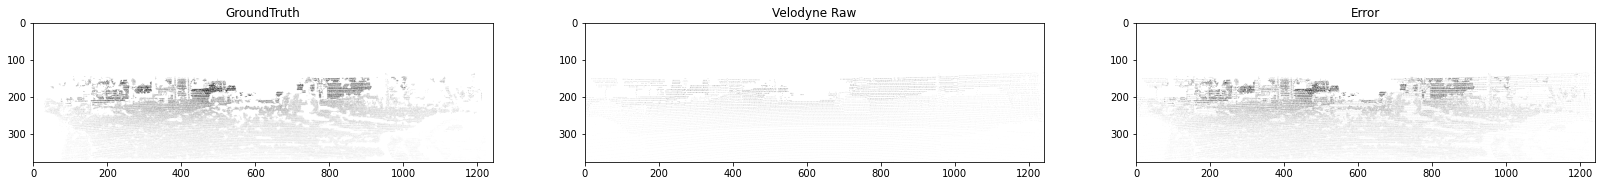

In [9]:
index = random.randint(0,len(training_data) - 1)
img = training_data[index][1] 
img_depth = training_data[index][0]
error = np.abs(img_depth - img)
img = img
error = error
fig = plt.figure(figsize = (28,15))

a = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(img, cmap='binary')
a.set_title('GroundTruth')

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(img_depth, cmap='binary')
a.set_title('Velodyne Raw')

a = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(error, cmap='binary')
a.set_title('Error')

**TensorFlow** takes input and output as seperate `numpy.array`. The **individual** element of the training data is a **2D** `numpy.array` and needs to be converted in a **3D** `numpy.array`. This is done by following lines-
```python
X = np.array(X).reshape(-1,375,1242,1)
Y = np.array(Y).reshape(-1,375,1242,1)
```
[`.reshape()`](https://https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) is a numpy in-built function to achieve such conversions.

In [10]:
X = []
Y = []
for i in tqdm(range(len(training_data))):
    X.append(training_data[i][0])
    Y.append(training_data[i][1])
X = np.array(X).reshape(-1,375,1242,1)
Y = np.array(Y).reshape(-1,375,1242,1)

100%|██████████| 656/656 [00:00<00:00, 88975.02it/s]


**Note:**<br>
Run the below cell to load the **libraries**. These libraries will be used **throughout** in learning and testing process.

In [0]:
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import layers, Input

### **Step V**: Training and Logging Convolution Network
This is an optional step with the objective to show the comparison between Sparsity Invariant CNN and Standard CNN in terms of the performance differences in interpolation task they are assigned. In order to get a reference of how to make **TensorFlow** **Neural Network models** and train them are as follows-<br>


1.   [Sentdex TensorFlow Playlist](https://www.youtube.com/playlist?list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN)
2.   [TensorFlow Tutorial on CNN](https://www.tensorflow.org/tutorials/images/cnn)
3.   [TensorFlow Documentation](https://www.tensorflow.org/api_docs/python/tf)

The brief overview of TensorFlow is that it has [three](https://www.pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/) method for *building neural network models* which are as follows-<br>
1. [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)
2. [Functional](https://www.tensorflow.org/guide/keras/functional)
3. [Model-SubClassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

Each of the following methods have their own use cases and have certain amount of **advantages** and **disadvantages** in different problem-statement. We realise this in our notebook itself. In case of **standard CNN** we have used the `tf.keras.sequential` and in case of **sparsity invariant CNN** we have used **Functional API.**

In [0]:
def sparse_MSE(target_y, predicted_y):
    binary_mask = tf.where(tf.equal(target_y, 0), tf.zeros_like(target_y), tf.ones_like(target_y))
    predicted_y = binary_mask * predicted_y
    loss = target_y - predicted_y
    loss = loss * loss 
    loss = tf.math.reduce_sum(loss) / tf.math.reduce_sum(binary_mask)
    return loss

```python
def sparse_MSE(target_y, predicted_y)
```
The above function is **modified** MeanSquaredError. We have used this function to calculate losses amongst only the **valid outputs** by creating a *binary mask* of the groundtruth to get a mask of **valid output** and then elementwise multiplying the **CNN output** by the mask and finally taking the mean amongst the valid output of the **groundtruth**.
The above loss function has some advantages and disadvantages which we will discuss futher in the notebook.

In [12]:
def create_CNN_model():
    model = Sequential()
    model.add(Conv2D(16, (11, 11), padding='same', activation='relu', input_shape=(375,1242,1)))
    model.add(MaxPooling2D(pool_size=(11,11),padding='SAME', strides=(1,1)))
    model.add(Conv2D(16, (7, 7), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(7,7),padding='SAME', strides=(1,1)))
    model.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(5,5),padding='SAME', strides=(1,1)))
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3),padding='SAME', strides=(1,1)))
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3),padding='SAME', strides=(1,1)))
    model.add(Conv2D(1, (1, 1), padding='same', activation='relu'))
    model.summary()
    return model
model = create_CNN_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 375, 1242, 16)     1952      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 375, 1242, 16)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 375, 1242, 16)     12560     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 375, 1242, 16)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 375, 1242, 16)     6416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 375, 1242, 16)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 375, 1242, 16)     2

<h3><strong>TensorFlow CallBacks and Logging</strong></h3>

When training on a **cloud-computer** or even on your **personal workstation** a situation might arise where the program might **crash**. However, TensorFlow has `callbacks` which help to save weights and losses at a particular frequency. In our case we have used the [`tf.keras.callbacks.CSVLogger`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/CSVLogger) for logging the losses and [`tf.keras.callbacks.ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) for saving the weights. All there are **few-problems** with the current logging which we have implemented like changing the **initial epochs** manually after program crashes and adding an additional line to load the weights from the file where the weights were last saved but it works.<br>
**Note-**<br>
If you using **Google Colab** the training might take **3 consecutive sessions** to be completed and logging becomes essential. 

In [13]:
import datetime
HISTNAME = f"{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}.csv"
FILENAME = f"{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}.ckpt"
print(FILENAME, HISTNAME)

20200523-132048.ckpt 20200523-132048.csv


In [0]:
os.chdir(ROOT_DIR)
checkpoint_path = f"Models/ConvNet/{FILENAME}"
logging_path = f"Models/ConvNet/{HISTNAME}"

if not os.path.exists('Models/ConvNet/'):
    os.makedirs('Models/ConvNet/')

with open(logging_path,'w+') as file:
    pass

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
log_callback = tf.keras.callbacks.CSVLogger(filename=logging_path, append=True)

<h3><strong>Choice of Parameters</strong></h3>

The main objective of training and testing to not only optimize the allotment of the resources and to speed up the task but also to **log** the losses at different **epochs** while **training** and **validation** to do the model analysis of the network. <br>
In this network `EPOCHS` is set to 15 which allows us to pinpoint the number of EPOCHS after which the network starts saturating as it can't further fit the data and the validation also seems to diverge. In our case we were not able to find a point where the training and validation losses started diverging but the losses surely reached a **saturation** and couldn't fit the data further.<br>
The `BATCH_SIZE` is set to 10 where as bare minimum of 32 is recommended. This is where resource limitation plays a factor. Our **TPU** has a memory of 12GB and after loading the model and training data has only enough memory to compute on a BATCH of size 10. This is one of the setback which we faced. Overall on our training data of 656 images the final testing data **MSE** was around 61 and final validation data **MSE** was around 51.
```python
model.compile(loss = sparse_MSE, optimizer = 'adam', metrics = ['accuracy','mean_squared_error', keras.metrics.RootMeanSquaredError()])
```
should be changed to
```python
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy','mean_squared_error', keras.metrics.RootMeanSquaredError()])
```
if you are interested to train on `MSE` instead of `sparse_MSE` defined earlier.

In [0]:
model.compile(loss = sparse_MSE, optimizer = 'adam', metrics = ['accuracy','mean_squared_error', keras.metrics.RootMeanSquaredError()])
model.fit(X, Y, 10, initial_epoch=0, epochs=15, validation_split=0.1, callbacks=[cp_callback, log_callback])

### **Step VI**: Training and Logging of Sparsity Invariant CNN (Main Implementation)<br>
Usually generated Depth-Maps are very low in resolution and have sparse output due to **fixed sampling rate** of depth-sensors. Sometimes those generated depth-maps have so **high sparsity** that it becomes **difficult** to actually process them. The **main** objective of Sparse CNN is to pass a depth-maps having some amount of sparsity into the network and generate an output which has close to **negligible sparse pixels** .<br>
Sparse Convolution is special type of covolution where only valid inputs are convolved and passed onto subsequent layers. We **pool** the **binary masks** instead of the convolved output and pass it onto the next layer and do further convolution.<br>

<table>
<tbody>
<tr>
<td><p align="center">
    <img src="https://i.ibb.co/9yhXpcK/Screenshot-from-2020-05-20-16-48-12.png" alt="Screenshot-from-2020-05-20-16-48-12" border="0">
</p></td>
<td><p align="center">
    <img src="https://i.ibb.co/0sJrtmC/Copy-of-Screenshot-from-2020-05-20-16-48-05.png" alt="Copy-of-Screenshot-from-2020-05-20-16-48-05" border="0">
</p></td>
<td><p align="center">
  <img src="https://raw.githubusercontent.com/PeterTor/sparse_convolution/master/pics/sparse.png">
</p></td>
</tr>
<tr>
    <td>
        <h6 align="center">Sparse Convolution</h6>
    </td>
    <td>
        <h6 align="center">Pooling of Binary Mask</h6>
    </td>
    <td>
        <h6 align="center">FlowChart</h6>
    </td>
</tr>
</tbody>
</table>


```python
sparse_conv(tensor,binary_mask = None,filters=32,kernel_size=3,strides=2,l2_scale=0.0)
```
The function definition contains the implementation regarding the network. When going through the function definition we need to know about **three core TensorFlow functions** [`tf.where()`](https://www.tensorflow.org/api_docs/python/tf/where) , [`tf.zeros_like()`](https://www.tensorflow.org/api_docs/python/tf/zeros_like) and [`tf.ones_like()`](https://www.tensorflow.org/api_docs/python/tf/ones_like). 

```python 
binary_mask = tf.where(tf.equal(channels[0], 0), tf.zeros_like(channels[0]), tf.ones_like(channels[0])) #mask should only have the size of (B,H,W,1)
```
generates the binary mask by using `tf.where()` conditionals which is elementwise multiplied by the `tensor`. In the first layer since we don't have a mask it needs to be generated and hence `None` is path however in subsequent layers the mask being one of the output of `sparse_conv` we pass it into the function.

```python
norm = layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=(strides, strides),kernel_initializer=tf.ones_initializer(),trainable=False,use_bias=False,padding="same")(binary_mask)
```
where you convolve the binary mask with a **all-ones-matrix** of same size as the `filters` dimension and you get the number of valid output which existed in that convolution to **normalize** the output features so that the output doesn't blow out of proportion.
```python
feature = layers.multiply([features,norm]) + b
mask = layers.MaxPooling2D(strides = strides,pool_size=kernel_size,padding="same")(binary_mask)
```
We make a separate trainable bias layer and pool the `binary_mask` and finally return the mask as well as feature which is used in **subsequent** sparse conv layer.

In [0]:
def sparse_conv(tensor,binary_mask = None,filters=32,kernel_size=3,strides=2,l2_scale=0.0):

    if binary_mask == None: #first layer has no binary mask
        b,h,w,c = tensor.get_shape()
        channels=tf.split(tensor,c,axis=3)
        #assume that if one channel has no information, all channels have no information
        binary_mask = tf.where(tf.equal(channels[0], 0), tf.zeros_like(channels[0]), tf.ones_like(channels[0])) #mask should only have the size of (B,H,W,1)

    features = layers.multiply([tensor,binary_mask])
    features = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=(strides, strides), use_bias=False, padding="same")(features)

    norm = layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=(strides, strides),kernel_initializer=tf.ones_initializer(),trainable=False,use_bias=False,padding="same")(binary_mask)
    norm = tf.where(tf.equal(norm,0),tf.zeros_like(norm),tf.math.reciprocal_no_nan(norm))
    _,_,_,bias_size = norm.get_shape()

    b = tf.Variable(tf.constant(0.0, shape=[bias_size]),trainable=True)
    b = tf.cast(b, 'float64')
    feature = layers.multiply([features,norm]) + b
    mask = layers.MaxPooling2D(strides = strides,pool_size=kernel_size,padding="same")(binary_mask)
    activation_layer = Activation('relu')

    return feature,mask

<p align="center">
  <img src="https://i.ibb.co/wBwwy1F/Screenshot-from-2020-05-20-17-16-49.png" alt="Screenshot-from-2020-05-20-17-16-49" border="0">
  <h3 align="center">Architecture of the Network</h3>
</p>

The above shown images establishes a basic flow of the network and tell us a lot about how to implement the network in **TensorFlow**. We will use `tf.Keras` functional API to implement our network due to involvement of multiple inputs and outputs which cannot be realised by `tf.keras.sequential` in an easier fashion. **TensorFlow's** `autograph` does a great job at autogenerating the forward and backward graph and apply **training to only** the convolution layer which interacts with the **features**.

In [14]:
tf.keras.backend.set_floatx('float64')
def create_SparseCNN_model():
    input = Input(shape=(375, 1242, 1), name='img', dtype='float64')
    x, mask = sparse_conv(input, None, 16, 11, 1)
    x, mask = sparse_conv(x, mask, 16, 7, 1)
    x, mask = sparse_conv(x, mask, 16, 5, 1)
    x, mask = sparse_conv(x, mask, 16, 3, 1)
    x, mask = sparse_conv(x, mask, 16, 3, 1)
    output, mask = sparse_conv(x, mask, 1, 1, 1)

    sparseNet = keras.Model(input, output, name='Sparse_CNN')
    sparseNet.summary()
    return sparseNet
sparseNet = create_SparseCNN_model()

Model: "Sparse_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 375, 1242, 1 0                                            
__________________________________________________________________________________________________
tf_op_layer_split (TensorFlowOp [(None, 375, 1242, 1 0           img[0][0]                        
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(4,)]               0           tf_op_layer_split[0][0]          
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 375, 1242, 1 0           tf_op_layer_split[0][0]          
_________________________________________________________________________________________

In [0]:
os.chdir(ROOT_DIR)
checkpoint_path = f"Models/SparseNet/{FILENAME}"
logging_path = f"Models/SparseNet/{HISTNAME}"

if not os.path.exists('Models/SparseNet/'):
    os.makedirs('Models/SparseNet/')

with open(logging_path,'w+') as file:
    pass

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
log_callback = tf.keras.callbacks.CSVLogger(filename=logging_path, append=True)

In [0]:
sparseNet.compile(loss = sparse_MSE, optimizer = 'adam', metrics = ['accuracy','mean_squared_error', keras.metrics.RootMeanSquaredError()])
sparseNet.fit(X, Y, 10, initial_epoch=0, epochs=15, validation_split=0.1, callbacks=[cp_callback, log_callback])

### **Observations, Conclusion and Reasons for Deviation-**
<p align="center">
<img src="https://i.ibb.co/m5L1nHJ/Sample-Final-Output.png" alt="Sample-Final-Output" border="0"><br>
<strong>Output of Models Trained on Different Parameters</strong>
</p>

After training each network for *15 epochs* we find that each trained model highlights a completely different feature about the depth image. Although training on one loss lead the other loss **going out of proportion**. On tabulating the losses for the particular models -

<table style="width:100%;">
    <thead>
        <th><strong>Model</strong></th>
        <th><strong>Mean Squared Error</strong></th>
        <th><strong>Sparsity Invariant MSE</strong></th>
    </thead>
    <tbody>
        <tr>
            <td><strong>Convolution Neural Network</strong></td>
            <td>35.578514099121094</td>
            <td>300.7381520721892</td>
        </tr>
        <tr>
            <td><strong>Convolution Neural Network<br> with Sparsity Invariant MSE</strong></td>
            <td>478.95782470703125</td>
            <td>23.973331008010895</td>
        </tr>
        <tr>
            <td><strong>Sparsity Invariant CNN</td>
            <td>36.86964851329173</td>
            <td>305.16724909358874</td>
        </tr>
        <tr>
            <td><strong>Sparsity Invariant CNN<br> with Sparsity Invariant MSE</strong></td>
            <td>411.74712360459324</td>
            <td>21.163065013406168</td>
        </tr>
    </tbody>
</table>

1. From the above table we see that if trained on **Sparsity Invariant MSE** the network trains slightly better and fits the training data much faster. However training on it would make the image less dense as compared to training on **Mean Squared Error**.
2. On the basis of the losses, **Sparsity invariant CNN** may not seem to have a edge over **Standard CNN**. However looking at the images it is pretty evident that sparsenets have **well-defined** boundaries and produce much **crisper depth maps**.
3. Training on **sparsity invariant MSE** preserve the depth relation way better than on **MSE** however training on **MSE** produce **denser** depth-maps. 


**Note-**<br>
In order to avoid training you can use our pretrained model with different **loss function** and **model** and generate the output. 


In [0]:
CONVNET_MSE = 'Models/ConvNet/20200521-182458.ckpt'
CONVNET_MODIFIED_MSE = 'Models/ConvNet/20200522-145004.ckpt'
SPARSENET_MSE = 'Models/SparseNet/20200522-124247.ckpt'
SPARSENET_MODIFIED_MSE = 'Models/SparseNet/20200522-144740.ckpt'

In [0]:
TEST_DIR = os.path.join(ROOT_DIR,'test')
input_folder, output_folder = os.listdir(TEST_DIR)
input_files = os.listdir(os.path.join(TEST_DIR, input_folder))
output_files = os.listdir(os.path.join(TEST_DIR, output_folder))

                                    MSE                   Sparsity Invariant MSE
SparseNet Losses on Standard MSE: 76.66140134815532 362.7629219902882
SparseNet Losses on Sparsity Invariant MSE: 316.40169962785194 127.01376846058479
ConvNet Losses on Standard MSE: 74.12996673583984 321.01013162292594
ConvNet Losses on Sparsity Invariant MSE: 359.3408203125 108.181884833607
Comparision with Raw Input: 106.39392255782059 512.977277773656


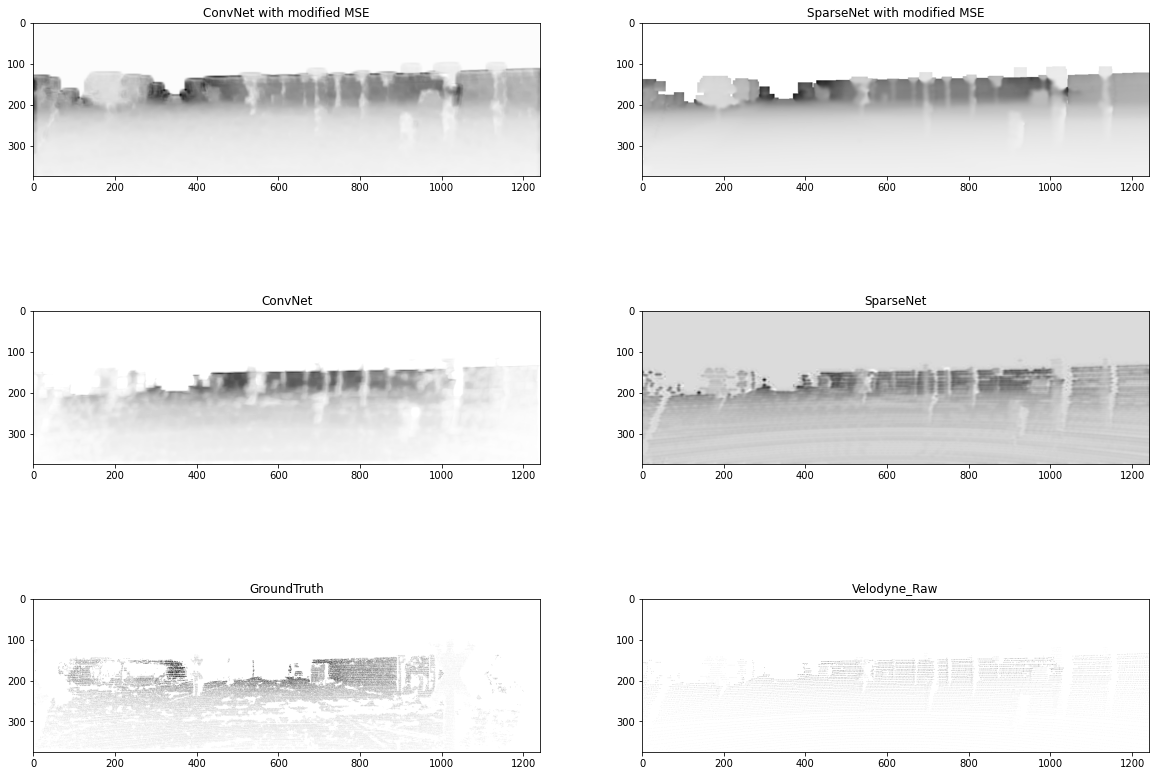

In [17]:
index = random.randint(0,len(input_files) - 1)
model.load_weights(CONVNET_MODIFIED_MSE)
sparseNet.load_weights(SPARSENET_MODIFIED_MSE)

img = depth_read(os.path.join(TEST_DIR, output_folder, output_files[index]))
raw_input = depth_read(os.path.join(TEST_DIR, input_folder, input_files[index]))

loss = tf.math.reduce_mean(tf.keras.losses.mean_squared_error(img, raw_input))
modified_loss = sparse_MSE(img, raw_input)

img_depth_sparse = sparseNet.predict(raw_input.reshape(-1, 375, 1242, 1)).reshape(375,1242)
img_depth_conv = model.predict(raw_input.reshape(-1, 375, 1242, 1)).reshape(375,1242)

modified_convnet_loss = tf.math.reduce_mean(tf.keras.losses.mean_squared_error(img, img_depth_conv))
modified_convnet_modified_loss = sparse_MSE(img, img_depth_conv)
modified_sparsenet_loss = tf.math.reduce_mean(tf.keras.losses.mean_squared_error(img, img_depth_sparse))
modified_sparsenet_modified_loss = sparse_MSE(img, img_depth_sparse)

fig = plt.figure(figsize = (20,15))

a = fig.add_subplot(3, 2, 1)
imgplot = plt.imshow(img_depth_conv, cmap='binary')
a.set_title('ConvNet with modified MSE')

a = fig.add_subplot(3, 2, 2)
imgplot = plt.imshow(img_depth_sparse, cmap='binary')
a.set_title('SparseNet with modified MSE')

model.load_weights(CONVNET_MSE)
sparseNet.load_weights(SPARSENET_MSE)
img_depth_sparse = sparseNet.predict(raw_input.reshape(-1, 375, 1242, 1)).reshape(375,1242)
img_depth_conv = model.predict(raw_input.reshape(-1, 375, 1242, 1)).reshape(375,1242)

convnet_loss = tf.math.reduce_mean(tf.keras.losses.mean_squared_error(img, img_depth_conv))
convnet_modified_loss = sparse_MSE(img, img_depth_conv)
sparsenet_loss = tf.math.reduce_mean(tf.keras.losses.mean_squared_error(img, img_depth_sparse))
sparsenet_modified_loss = sparse_MSE(img, img_depth_sparse)

a = fig.add_subplot(3, 2, 3)
imgplot = plt.imshow(img_depth_conv, cmap='binary')
a.set_title('ConvNet')

a = fig.add_subplot(3, 2, 4)
imgplot = plt.imshow(img_depth_sparse, cmap='binary')
a.set_title('SparseNet')

a = fig.add_subplot(3, 2, 5)
imgplot = plt.imshow(img, cmap='binary')
a.set_title('GroundTruth')

a = fig.add_subplot(3, 2, 6)
imgplot = plt.imshow(raw_input, cmap='binary')
a.set_title('Velodyne_Raw')

print(" "*35,"MSE                  ", "Sparsity Invariant MSE" )
print("SparseNet Losses on Standard MSE:", float(sparsenet_loss), float(sparsenet_modified_loss))
print("SparseNet Losses on Sparsity Invariant MSE:", float(modified_sparsenet_loss), float(modified_sparsenet_modified_loss))
print("ConvNet Losses on Standard MSE:", float(convnet_loss), float(convnet_modified_loss))
print("ConvNet Losses on Sparsity Invariant MSE:", float(modified_convnet_loss), float(modified_convnet_modified_loss))
print("Comparision with Raw Input:", float(loss), float(modified_loss))

<h3><strong>Graphs and Trends</strong></h3>
<p align="center">
<img src="https://i.ibb.co/vHPw03t/Final-Graphs.png" alt="Final-Graphs" border="0"><br>
<strong>Graphs for Losses, Errors of Different Model</strong>
</p>

1. From the graphs we can see that **Sparsity Invariant CNNs** perform way better than Convolution Neural Networks. It converges faster than CNNs even after training on a subset of data and produces much better output.
2. It is evident from the graph that training a network on one loss may not lead to reduction in other errors. Trainin on **Sparsity Invariant MSE** led to increase in **MSE** by a very large value and vice versa as it was shown in the above listed table.
3. The losses converged must faster in case of **Sparsity Invariant MSE** as compared to **MSE**. The reason could be the modified MSE suited the problem statement better because it is rare for groundtruth to have a 0% sparsity. This forced the network to only compare on the regions where the values are not sparse.

The purpose of the graphs was to show the trends in the network. However using matplotlib in notebook doesn't allow you to zoom in and zoom out of the graphs.

<p align="center">
<img src="https://i.ibb.co/PFZxP7S/Loss-Comparision.png" alt="Loss-Comparision" border="0"><br> <strong>Loss Comparision to Show Convergence</strong></p>

Even though we are training on completely different loss functions and therefore the only reason to show this graph is to show how fast the graph converges when we change the loss function.

**Reasons for Deviation-**<br>
The trends of our model slightly deviates from the trends shown in the research paper due to the following reasons-
1. **Lack of resources.** Processing, conversion and training of data requires physical and gpu memory. Even though training on Colab provides us with a significant amount of resources however it's not enough to do any justification because we are dealing with high-resolution images.
2. **Reduced Batch Size.** As contrary to 32 `BATCH_SIZE` which is minimum recommended batch size for training we are fixed to a batch size of 10 because increase the batch size used to lead to crashing of programs during initialisation of model or in-between training.
3. **Limitations of the Library.** TensorFlow is a great library for training and realising Neural Networks however libraries also have some amount of approximations involved. There were some instances where our program used to crash in between training and we had to reload the last saved weights and since saving takes place after every epoch, it would lead to rerunning an epoch just because the training of that epoch couldn't finish.
4. **Extension to Previous Point.** Training on a notebook sometimes would lead to using an exisitng model or variable even after that cell being executed. This would lead to errors significantly reducing in the first epoch only but would lead to a misinterpreted graph. As you can see the spike in the ConvNet as shown in the graph above, the sole reason for that spike was the program crashing and retraining the model from that epoch lead to increased loss due to unknown reason however the loss reduced to a normal value in the subsequent epochs.

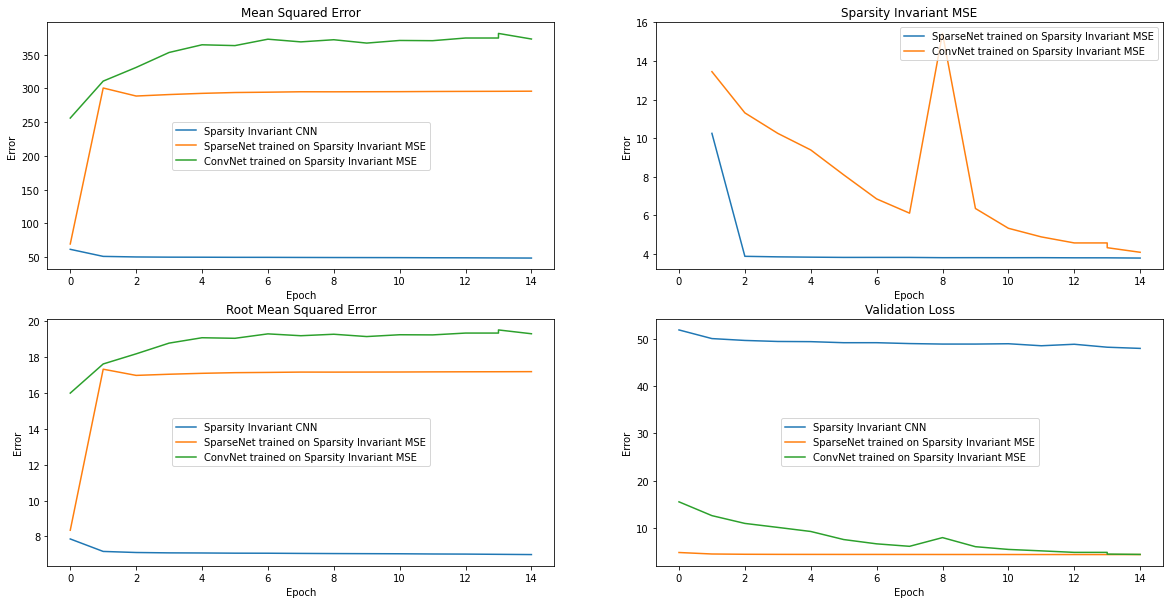

In [31]:
import pandas as pd
STATISTICS_DIR = os.path.join(ROOT_DIR,'Statistics')
sparse_normal_loss = pd.read_csv(os.path.join(STATISTICS_DIR, 'SparseCNN with standard MSE.csv'))
conv_modified_loss = pd.read_csv(os.path.join(STATISTICS_DIR, 'CNN with Modified MSE.csv'))
sparse_modified_loss = pd.read_csv(os.path.join(STATISTICS_DIR, 'SparseCNN with Modified MSE.csv'))

fig = plt.figure(figsize = (20,10))
ax1 = plt.subplot2grid((2,2),(0, 0))
ax2 = plt.subplot2grid((2,2),(0, 1), sharex=ax1)
ax3 = plt.subplot2grid((2,2),(1, 0), sharex=ax1)
ax4 = plt.subplot2grid((2,2),(1, 1), sharex=ax1)

ax1.plot(sparse_normal_loss.epoch , sparse_normal_loss.mean_squared_error, label='Sparsity Invariant CNN')
ax1.plot(sparse_modified_loss.epoch, sparse_modified_loss.mean_squared_error, label='SparseNet trained on Sparsity Invariant MSE')
ax1.plot(conv_modified_loss.epoch, conv_modified_loss.mean_squared_error, label='ConvNet trained on Sparsity Invariant MSE')

ax2.plot(sparse_modified_loss.epoch[1:], sparse_modified_loss.loss[1:], label='SparseNet trained on Sparsity Invariant MSE')
ax2.plot(conv_modified_loss.epoch[1:], conv_modified_loss.loss[1:], label='ConvNet trained on Sparsity Invariant MSE')

ax3.plot(sparse_normal_loss.epoch , sparse_normal_loss.root_mean_squared_error, label='Sparsity Invariant CNN')
ax3.plot(sparse_modified_loss.epoch, sparse_modified_loss.root_mean_squared_error, label='SparseNet trained on Sparsity Invariant MSE')
ax3.plot(conv_modified_loss.epoch, conv_modified_loss.root_mean_squared_error, label='ConvNet trained on Sparsity Invariant MSE')

ax4.plot(sparse_normal_loss.epoch , sparse_normal_loss.val_loss, label='Sparsity Invariant CNN')
ax4.plot(sparse_modified_loss.epoch, sparse_modified_loss.val_loss, label='SparseNet trained on Sparsity Invariant MSE')
ax4.plot(conv_modified_loss.epoch, conv_modified_loss.val_loss, label='ConvNet trained on Sparsity Invariant MSE')

ax1.set(xlabel='Epoch', ylabel='Error')
ax2.set(xlabel='Epoch', ylabel='Error')
ax3.set(xlabel='Epoch', ylabel='Error')
ax4.set(xlabel='Epoch', ylabel='Error')

ax1.title.set_text('Mean Squared Error')
ax2.title.set_text('Sparsity Invariant MSE')
ax3.title.set_text('Root Mean Squared Error')
ax4.title.set_text('Validation Loss')

ax1.legend(loc='center')
ax2.legend(loc='upper right')
ax3.legend(loc='center')
ax4.legend(loc='center')

plt.show()

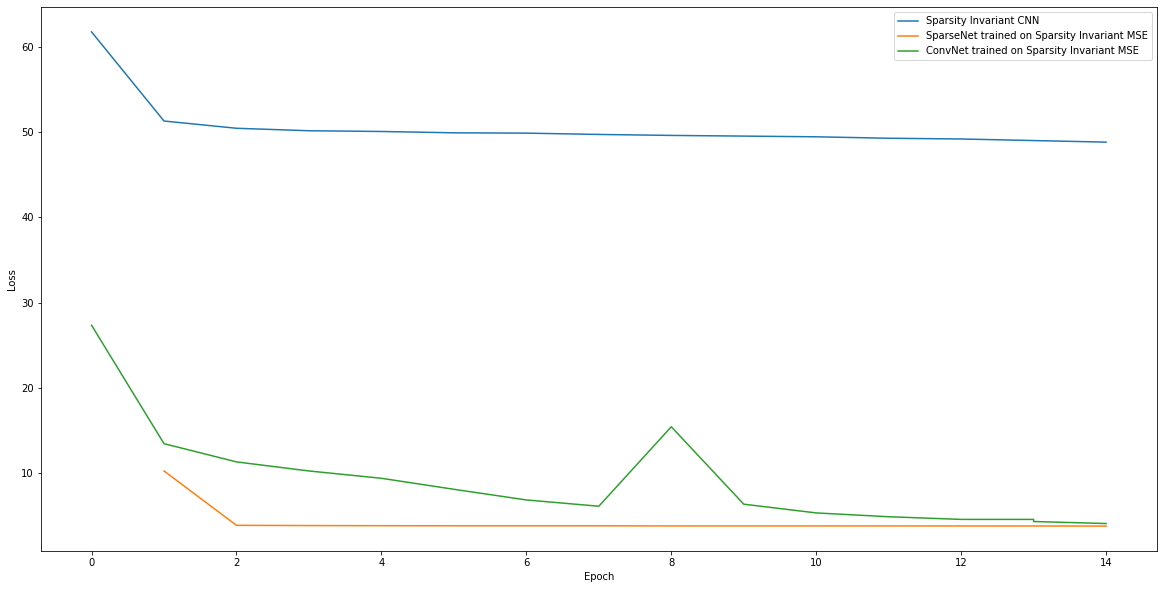

In [32]:
fig = plt.figure(figsize = (20,10))
plt.plot(sparse_normal_loss.epoch , sparse_normal_loss.loss, label='Sparsity Invariant CNN')
plt.plot(sparse_modified_loss.epoch[1:], sparse_modified_loss.loss[1:], label='SparseNet trained on Sparsity Invariant MSE')
plt.plot(conv_modified_loss.epoch, conv_modified_loss.loss, label='ConvNet trained on Sparsity Invariant MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

### **Personal Takeaway** <br>
This project taught us a lot about **Sparsity Invariant CNNs** as well as solidified our concepts on Convolution Neural Networks in general. Before shifting to TensorFlow we made our project on PyTorch and it helped us learn a lot about both the libraries and advantages and disadvantages of both the libraries. PyTorch is easier to grasp and use for beginners but is difficult to troubleshoot on the other hand TensorFlow has methods and procedures for a lot of test cases. PyTorch is more modular than TensorFlow but for troubleshooting you need to dwelve deeper into the library on the other hand when it comes to troubleshooting on TensorFlow it's as easy as using a different function from pool of thousand functions they provide.

Coming to the project, it made us realise that neural networks are more than a blackbox trying to jot down a relation between input and output. Sometimes using standard programming techniques and analysing a problem statement at a level deeper than just collecting the dataset and labelling it helps us to solve the problem statement at a significant faster rate. In case of our project we came to a realisation that using a standard convolution won't do any justice to the problem statement becuase we are ignoring the major factor of sparsity in depth maps and modifying the convolution to only work on the valid values helps us solve the problem statement.

We would like to thank our **Prof. Surekha Bhanot** and **Prof. Bijoy Mukherjee** for providing us with the chance to work on this project. We would also like to thank our **TA Rishav** for guiding us and solving our doubts we faced while implementing the paper. This project makes us more enthusiastic to dwelve deeper into Neural Networks and appreciate it's untapped potential.